In [459]:
from graphviz import Digraph, nohtml
from bisect import insort_left, bisect_left
from math import floor
from random import randint

# Arbres-B
Sources : Cours d'AlgAv et Sedgewick Wayne - Algorithms 4th edition

Pour un arbre d'ordre m:
- Noeuds : m <= k <= 2m clés
- Racine : 1 <= k <= 2m clés

# Table des matières <a class="anchor" id="menu"></a>
* [Graphviz](#graphviz)
* [Arbre-B et PageB](#btree)
* [Tests](#tests)
<!-- * [Arbre-B et PageB V2](#btree2) -->

## Graphviz <a class="anchor" id="graphviz"></a>                                                                                                                                  
#### [Retour](#menu) 

In [460]:
def visualiser_arbre(arbreB):
    # dot = Digraph()
    dot = Digraph(node_attr={'shape': 'record', 'height': '.1'})
    index = 0

    def bufferNoeud(cles):
        buffer = "<f0> |"
        for i in range(len(cles)):
            buffer += "<f" + str(2*i+1) + "> " + str(cles[i]) + "|" # case cle : indice impair
            if i != len(cles)-1:
                buffer += "<f" + str(2*i+2) + "> " + "|" # case pointeur vers enfant : indice pair
            else:
                buffer += "<f" + str(2*i+2) + "> "
        return buffer

        # for i in range(1,nbCases):
        #     if i % 2 == 1: # cle
        #         buffer += "<f" + str(i) + "> " + str(cles[i]) + "|"
        #     else:
        #         buffer += "<f" + str(i) + "> " + "|"
        # # buffer += "<f" + str(nbCases) + "> " + str(cles[-1]) # derniere cle sans le "|"
        # return buffer


        # if cle is None:
        #     buffer += "<f" + str(indice) + "> "
        # else:
        #     buffer += "<f" + str(indice) + "> " + str(cle)
        # if not estDerniereCle:
        #     buffer += "|"
        # return buffer
    
    def traverse(pageB):
        nonlocal index

        if pageB is None:
            return

        buffer = bufferNoeud(pageB.cles)
        dot.node(str(index), nohtml(buffer))
        # index += 1
        
        idParent = index
        for i in range(len(pageB.enfants)):
            parent = str(idParent) + ":f" + str(2*i)
            index += 1
            enfant = str(index)
            dot.edge(parent, enfant)
            traverse(pageB.enfants[i])
    
    traverse(arbreB.racine)
    return dot

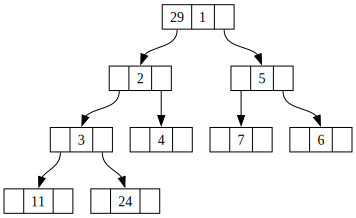

In [461]:
# test graphviz - source : https://graphviz.readthedocs.io/en/stable/examples.html#btree-py

g = Digraph(node_attr={'shape': 'record', 'height': '.1'})

g.node('node0', nohtml('<f0> 29|<f1> 1|<f2>'))
g.node('node1', nohtml('<f0> |<f1> 2|<f2>'))
g.node('node2', nohtml('<f0> |<f1> 3|<f2>'))
g.node('node3', nohtml('<f0> |<f1> 4|<f2>'))
g.node('node4', nohtml('<f0> |<f1> 5|<f2>'))
g.node('node5', nohtml('<f0> |<f1> 7|<f2>'))
g.node('node6', nohtml('<f0> |<f1> 6|<f2>'))
g.node('node7', nohtml('<f0> |<f1> 11|<f2>'))
g.node('node8', nohtml('<f0> |<f1> 24|<f2>'))

g.edge('node0:f2', 'node4:f1')
g.edge('node0:f0', 'node1:f1')
g.edge('node1:f0', 'node2:f1')
g.edge('node1:f2', 'node3:f1')
g.edge('node2:f2', 'node8:f1')
g.edge('node2:f0', 'node7:f1')
g.edge('node4:f2', 'node6:f1')
g.edge('node4:f0', 'node5:f1')

g

## Arbre-B et PageB <a class="anchor" id="btree"></a>                                                                                                                                  
#### [Retour](#menu) 

In [462]:
class PageB:
    def __init__(self, cles:'list'=[]):
        self.cles = cles # nbCles noeud : entre m et 2m, nbCles racine : entre 1 et 2m
        self.enfants = []
        self.parent = None

    def _est_page_vide(self):
        """ Retourne true si la page self est vide (sans cle).
        """
        return self.cles == []

    def _est_page_externe(self):
        """ Retourne true si self est une page externe (feuille).
        """
        return len(self.enfants) == 0

    def _est_debordement_page(self, nbMaxCles):
        """ Retourne true si la page self depasse sa limite de cles (2*ordre).    
        """
        return len(self.cles) > nbMaxCles
    
    def _est_suppression_sans_deficit(self, nbMinCles):
        """ Retourne true si la suppression d'une cle de la page self n'entraine pas
            de deficit en cle ie. si len(self.cles) > nbMinCles (racine : minimum 1 cle
            et noeud : minimum m cles, avec m = ordre de l'arbreB).
        """
        if self.parent is None: # racine : nbCles min = 1 -> cas utile ?
            return len(self.cles) > 1
        else: # noeud : nbCles min = m
            return len(self.cles) > nbMinCles
    
    def _est_page_en_deficit(self, nbMinCles):
        """ Retourne true si la page self est en deficit de cle ie. si len(self.cles) < nbMinCles.
        """
        if self.parent is None: # racine : nbCles min = 1
            return len(self.cles) < 1
        else: # noeud : nbCles min = m
            return len(self.cles) < nbMinCles

    def _recherche_page(self, cle):
        """ Retourne true si cle est dans la page self.
        """
        return cle in self.cles
    
    def _indice_page_suivante(self, cle):
        """ Retourne l'indice de la page suivante (enfant de la page self) qui pourrait
            contenir la cle cle.
            Hypothese : self n'est pas une page externe (sinon pas de page suivante)
            (hypothese verifiee dans la fonction _recherche(arbreB, pageB, cle))
        """
        assert not self._est_page_externe(), "indicePageSuivante : self est une page externe, pas de page suivante!"
        indice = bisect_left(self.cles, cle)
        # print(self.cles, cle)
        return indice
    
    def _frere_gauche(self) -> 'PageB':
        """ Retourne le frere gauche de la page self s'il existe,
            None si self ne possede pas frere gauche (self est
            la racine ou l'enfant le plus a gauche de son parent).
        """
        print("je suis", self.cles, "et je cherche mon frere gauche")
        if self.parent is None: # self est la racine : pas de frere
            return None
        else:
            print("j'ai un parent !", self.parent.cles)
            indice = self.parent.enfants.index(self) # indice de self parmi les enfants de son parent
            if indice == 0: # pas de frere gauche
                return None
            else:
                return self.parent.enfants[indice - 1]
            
    def _frere_droit(self) -> 'PageB':
        """ Retourne le frere droit de la page self s'il exitse,
            None si self ne possede pas de frere droit (self est
            la racine ou l'enfant le plus a droite de son parent).
        """
        if self.parent is None: # self est la racine : pas de frere
            return None
        else:
            indice = self.parent.enfants.index(self) # indice de self parmi les enfants de son parent
            if indice == len(self.parent.enfants) - 1: # pas de frere droit
                return None
            else:
                return self.parent.enfants[indice + 1]

    def _emprunter_cle_frere(self, frere:'PageB', estGauche:bool):
        """ Emprunte une cle a son frere gauche ou droit. Echange la
            cle avec une cle du parent pour respecter l'ordre des cles.
            Si self n'est pas une feuille, elle recupere un enfant du frere.
            Hypothese : l'emprunt d'une cle a son frere n'entraine pas
            de deficit (le possible deficit en cles du parent n'est pas
            traite dans cette fonction mais en dehors).
        """
        if estGauche:
            cleEmpruntee = frere.cles.pop(len(frere.cles)-1)
            indice = self.parent.enfants.index(frere) # gauche -> indice cle enfant gauche
            if not self._est_page_externe(): # self doit recuperer un enfant du frere (sinon deficit enfants)
                enfantFrere = frere.enfants.pop(len(frere.enfants)-1) # frere gauche cede son dernier enfant a self
                enfantFrere.parent = self # update du parent de l'enfant recupere
                self.enfants.insert(0, enfantFrere) # l'enfant du frere gauche devient le 1er enfant de self
        else:
            cleEmpruntee = frere.cles.pop(0)
            indice = self.parent.enfants.index(self) # droite -> indice cle enfant self
            if not self._est_page_externe(): # self doit recuperer un enfant du frere (sinon deficit enfants)
                enfantFrere = frere.enfants.pop(0) # frere droit cede son 1er enfant a self
                enfantFrere.parent = self # update du parent de l'enfant recupere
                self.enfants.append(enfantFrere) # l'enfant du frere droit devient le dernier enfant de self
        cleParent = self.parent.cles.pop(indice) # parent echange cle pour respecter l'ordre
        self.parent.cles.insert(indice, cleEmpruntee)
        insort_left(self.cles, cleParent) # self recupere cle parent



    def _cle_predecesseur_max_dans_enfant(self):
        """ Retourne la cle predecesseur max du sous-arbre.
        """
        if self._est_page_externe(): # feuille : recuperer la cle max
            return self.cles[len(self.cles)-1]
        else: # noeud interne : continuer a chercher dans le sous-arbre droit
            return self.enfants[len(self.enfants)-1]._cle_predecesseur_max_dans_enfant()

    

    def _est_emprunt_possible(self, frereGauche:'PageB', frereDroit:'PageB', nbMinCles):
        if frereGauche is None and frereDroit is None: # pas de frere : emprunt impossible
            return False
        # sinon, au moins un des freres est pas None
        # si gauche None alors droit pas None (gauche impossible -> depend de droit)
        if frereGauche is None:
            return frereDroit._est_suppression_sans_deficit(nbMinCles)
        # sinon, gauche pas None et droit None -> depend de gauche
        else:
            return frereGauche._est_suppression_sans_deficit(nbMinCles)

    def _ajout_page_externe(self, cle):
        """ Ajoute la cle cle dans la page externe self.
        """
        assert self._est_page_externe(), "ajoutPageExterne : pas une page externe!"
        insort_left(self.cles, cle)

    def _eclatement(self):
        """ Eclate la page courante self en deux pages. La cle mediane est
            recuperee par le parent de self et les enfants de self sont
            partages entre les deux nouvelles pages.
            Si self n'a pas de parent (cas de la racine), une nouvelle
            racine est creee.
            Retourne soit le parent de self, soit la nouvelle racine.
            Hypothese : eclatement si len(self.cles) > 2*ordre (debordement)
        """
        # Etapes :
        # - eclater self en 2 : clesMoitiesGauche et clesMoitieDroite
        #   en 2 nouvelles pages -> deviennent les enfants du parent de
        #   self (et supprimer self des enfants de son parent)
        # - le parent recupere la cle mediane de self.cles
        # - les enfants de self enfantsGauche et enfantsDroite deviennent
        #   respectivement les enfants de la page associee a 
        #   clesMoitieGauche/Droite (remarque : si self a k cles alors self
        #   a k+1 enfants -> nombre d'enfants donc egal a 2*(ordre+1) -> pair)
        # - cas 1 : self a un parent -> suivre les etapes du dessus
        # - cas 2 : self n'a pas de parent car c'est la racine
        #   -> creer une nouvelle racine qui a pour unique
        #      cle la cle mediane et comme enfants les 2 nouvelles pages

        moitie = floor(len(self.cles)/2)
        cleMediane = self.cles[moitie]
        pageMoitieGauche = PageB(self.cles[:moitie]) # indice moitie pas inclus
        pageMoitieDroite = PageB(self.cles[moitie+1:]) # indice moitie+1 inclus

        if not self._est_page_externe(): # nb enfants = nb cles+1
            pageMoitieGauche.enfants = self.enfants[:moitie+1] # les nouvelles pages recuperent
            pageMoitieDroite.enfants = self.enfants[moitie+1:] # les enfants de self
            for page in self.enfants[:moitie+1]:
                page.parent = pageMoitieGauche
            for page in self.enfants[moitie+1:]:
                page.parent = pageMoitieDroite

        if self.parent is None: # self est racine -> creer nv racine
            nvRacine = PageB([cleMediane])
            nvRacine.enfants = [pageMoitieGauche, pageMoitieDroite]
            pageMoitieGauche.parent = nvRacine
            pageMoitieDroite.parent = nvRacine
            self.parent = nvRacine
            return nvRacine
        else: # un parent
            insort_left(self.parent.cles, cleMediane) # le parent recupere cle mediane
            self.parent.enfants.remove(self)
            i = bisect_left(self.parent.cles,pageMoitieGauche.cles[0])
            self.parent.enfants.insert(i, pageMoitieGauche)
            # i = bisect_left(self.parent.cles,pageMoitieDroite.cles[0])
            self.parent.enfants.insert(i+1, pageMoitieDroite)
            pageMoitieGauche.parent = self.parent
            pageMoitieDroite.parent = self.parent
            return self.parent

    def _dupliquePage(self, parent:'PageB'=None):
        """ Retourne le duplique de la page self.
        """
        duplique = PageB(self.cles.copy())
        duplique.parent = parent
        for enfant in self.enfants:
            duplique.enfants.append(enfant._dupliquePage(duplique))
        return duplique


    def _fusion_page(self, frere:'PageB', estGauche:bool):
        """ Fusionne la page self avec une page frere gauche en ajoutant les cles de
            self dans celles de frere. Descend une cle du parent pour respecter
            l'ordre des cles dans l'ArbreB. Recupere les enfants de self et du frere.
            Retourne la page resultante.
        """
        fusion = PageB() # page contenant la fusion des cles de frere et self
        fusion.parent = self.parent
        indice = -1
        if estGauche:
            # recuperer l'indice de la cle du parent a descendre (celle entre frere gauche et self)
            indice = fusion.parent.enfants.index(frere) # gauche -> indice cle enfant gauche
            cleParent = fusion.parent.cles.pop(indice) # cle a descendre (et a supprimer du parent)
            fusion.cles = frere.cles + [cleParent] + self.cles
            fusion.enfants = frere.enfants + self.enfants # recuperer les enfants
        else: # frere droite
            # recuperer l'indice de la cle du parent a descendre (celle entre self et frere droit)
            indice = fusion.parent.enfants.index(self) # droite -> indice cle enfant self
            cleParent = fusion.parent.cles.pop(indice) # cle a descendre (et a supprimer du parent)
            fusion.cles = self.cles + [cleParent] + frere.cles
            fusion.enfants = self.enfants + frere.enfants # recuperer les enfants
        for enfant in fusion.enfants:
            enfant.parent = fusion
        # print("fusion : indice !", indice, "et len du parent !", len(fusion.parent.cles))
        fusion.parent.enfants.remove(self) # retirer self des enfants du parent
        fusion.parent.enfants.remove(frere) # retirer frere des enfants du parent
        fusion.parent.enfants.insert(indice, fusion) # ajouter la page resultante dans les enfants du parent
        return fusion
    

        

class ArbreB:
    def __init__(self, ordre):
        assert ordre > 0, "ArbreB : veuillez choisir un ordre strictement positif!"
        self.racine = None
        self.ordre = ordre # ordre = nombre de cles min dans un noeud non racine
        self.NBCLESMAX = 2*ordre
    
    def _estVide(self):
        return self.racine is None
    
    def _duplique(self):
        """ Retourne le duplique de l'ArbreB self.
        """
        duplique = ArbreB(self.ordre)
        duplique.racine = self.racine._dupliquePage()
        return duplique
 
    def recherche(self, cle):
        """ Retourne true si cle est dans l'arbre-B self en
            cherchant dans les pagesB de l'arbre-B a l'aide
            de la fonction _recherche(pageB, cle).
        """
        if self._estVide():
            return False
        return self._recherche(self.racine, cle)
    
    def _recherche(self, page:PageB, cle):
        """ Retourne true si la cle est dans l'arbre-B self en
            cherchant si la cle est dans une pageB de l'arbre.
        """
        if page._recherche_page(cle): # cle est dans la page courante
            return True
        else: # sinon continuer a chercher
            if page._est_page_externe(): # pas d'enfant : fin recherche
                return False
            else: # chercher dans la page suivante qui pourrait contenir la cle
                pageSuivante = page.enfants[page._indice_page_suivante(cle)]
                return self._recherche(pageSuivante, cle)


    def ajout(self, cle):
        if self._estVide():
            self.racine = PageB([cle])
        else:
            self._ajout(self.racine, cle)


    def _ajout(self, page:PageB, cle):
        if page._recherche_page(cle): # cle deja dans une page de arbre-B
            return

        if page._est_page_externe(): # page externe (feuille) : ajout ok
            page._ajout_page_externe(cle)

        else: # ajout dans page suivante (enfant)
            pageSuivante = page.enfants[page._indice_page_suivante(cle)]
            self._ajout(pageSuivante, cle)

        if page._est_debordement_page(self.NBCLESMAX):
            if page.parent is None: # cas augmentation hauteur
                page = page._eclatement()
                self.racine = page # page est devenue la racine
            else:
                page = page._eclatement()

                    

    def suppression(self, cle):
        if self._estVide():
            return
        else:
            self.racine = self._suppression(self.racine, cle)


    def _suppression(self, page:PageB, cle):
        print("mes cles !", page.cles)
        if page._recherche_page(cle): # on a trouve la cle a supprimer
            if page.parent is None and len(page.cles) == 1 and page.enfants == []: # arbreB = 1 cle a la racine
                # self.racine = None
                return None
            if page._est_page_externe(): # suppression au niveau d'une feuille : ok
                print("je suis une feuille !", page.cles, "suppression de", cle)
                page.cles.remove(cle)
                # Si suppression entraine un deficit de cles dans la page :
                # emprunter cle predecesseur ou successeur si possible. Le
                # parent recupere la cle empruntee et descend une cle en
                # echange.
                # Sinon, fusionner avec frere gauche et parent descend une cle.
                # Si parent en deficit, parent prend une cle de son frere et un
                # enfant. Si impossible, fusionner avec parent et frere.
                # Si apres emprunt/fusion, parent plus de cle, supprimer noeud vide
                # Si apres emprunt/fusion, parent en deficit, fusion en remontee
                print("apres suppression feuille, je verifie les prop de l'arbre !", page.cles)
                if page._est_page_en_deficit(self.ordre):
                    print("je suis en deficit !", page.cles)
                    # un des freres est pas None car cas racine deja traite
                    frereGauche = page._frere_gauche()
                    frereDroit = page._frere_droit()
                    if page._est_emprunt_possible(frereGauche, frereDroit, self.ordre):
                        print("emprunt possible !", page.cles)
                        if frereGauche is not None and frereGauche._est_suppression_sans_deficit(self.ordre):
                            print("emprunt frere gauche !", frereGauche.cles)
                            page._emprunter_cle_frere(frereGauche, estGauche=True)
                        elif frereDroit is not None and frereDroit._est_suppression_sans_deficit(self.ordre):
                            print("emprunt frere droit !", frereDroit.cles)
                            page._emprunter_cle_frere(frereDroit, estGauche=False)
                    else: # si emprunt impossible -> fusion
                        print("emprunt impossible !", page.cles)
                        if frereGauche is not None: # fusion avec gauche
                            print("fusion avec frere gauche !", frereGauche.cles)
                            page = page._fusion_page(frereGauche, estGauche=True)
                        else: # sinon, fusion avec droit
                            print("fusion avec frere droit !", frereDroit.cles)
                            page = page._fusion_page(frereDroit, estGauche=False)
            # sinon, suppression pas dans une feuille : recuperer la cle predecesseur de son
            # enfant par rapport a la cle a supprimer (la plus grande cle du sous-arbre gauche),
            # echanger puis supprimer la cle predecesseur
            else:
                indice = page.cles.index(cle)
                print("indice enfant où chercher cle pred", indice)
                pagePrecedente = page.enfants[indice]
                # i = page.enfants.index(pagePrecedente)
                cleRemplacement = pagePrecedente._cle_predecesseur_max_dans_enfant()
                print("cle pred à cle !", cleRemplacement, cle)
                page.cles[indice] = cleRemplacement # echanger cle a supprimer par cle predecesseur
                return self._suppression(pagePrecedente, cleRemplacement) # supprimer cle predecesseur du sous-arbre
        else: # continuer a chercher la cle a supprimer
            if page._est_page_externe():
                print("ArbreB suppression : cle non trouvee dans l'arbreB !")
                return page
            print("continuer a chercher dans la page suivante", cle)
            indice = page._indice_page_suivante(cle)
            pageSuivante = page.enfants[indice]
            return self._suppression(pageSuivante, cle)
        print("je suis", page.cles, "et j'ai fini de supprimer", cle,"et je verifie les prop de l'arbre !" )
        parent = page.parent
        print("parent !", parent.cles)
        while parent is not None: # page n'est pas la racine -> verifier parent
            # si parent plus de cle apres emprunt/fusion, c'etait la racine -> diminution hauteur
            if parent._est_page_vide(): # parent = racine mais pas de cle, cas diminution hauteur
                print("diminution hauteur parent vide!", parent.cles)
                if len(parent.enfants) == 1: # racine = unique enfant
                    print("je suis enfant unique !", page.cles)
                else: # fusion page et frere
                    frereGauche = page._frere_gauche()
                    frereDroit = page._frere_droit()
                    if frereGauche is not None:
                        print("je suis", page.cles, "fusion avec frere gauche !", frereGauche.cles)
                        page = page._fusion_page(frereGauche, estGauche=True)
                    else:
                        print("je suis", page.cles, "fusion avec frere droit !", frereDroit.cles)
                        page = page._fusion_page(frereDroit, estGauche=False)
                page.parent = None
                self.racine = page
                break
            if parent._est_page_en_deficit(self.ordre): # emprunt ou fusion
                print("parent en deficit !", parent.cles)
                parentFrereGauche = parent._frere_gauche()
                parentFrereDroit = parent._frere_droit()
                # cas emprunt
                if parent._est_emprunt_possible(parentFrereGauche, parentFrereDroit, self.ordre):
                    print("parent peut emprunter !", parent.cles)
                    if parentFrereGauche is not None and parentFrereGauche._est_suppression_sans_deficit(self.ordre):
                        print("emprunt frere gauche parent !", parentFrereGauche.cles)
                        parent._emprunter_cle_frere(parentFrereGauche, estGauche=True)
                    elif parentFrereDroit is not None and parentFrereDroit._est_suppression_sans_deficit(self.ordre):
                        print("emprunt frere droit parent !", parentFrereDroit.cles)
                        parent._emprunter_cle_frere(parentFrereDroit, estGauche=False)
                else: # cas fusion
                    print("parent doit fusionner !", parent.cles)
                    if parentFrereGauche is not None:
                        print("fusion avec frere gauche parent !", parentFrereGauche.cles)
                        parent = parent._fusion_page(parentFrereGauche, estGauche=True)
                    elif parentFrereDroit is not None:
                        print("fusion avec frere droit parent !", parentFrereDroit.cles)
                        parent = parent._fusion_page(parentFrereDroit, estGauche=False)
            page = parent
            parent = page.parent
        if page.parent is not None :
            print("Apres verification !", page.cles, parent.cles)
        return page
    


    def suppression_version_preemptive(self, cle):
        """ Suppression de la cle cle dans l'arbre-B self en utilisant
            une verification preemptive des proprietes de l'arbre-B avant 
            de descendre dans un noeud. Cf. Cormen Introduction a l'algorithmique.
            Hypothese : l'ordre de l'arbre-B est pair.
            Remarque : la suppression preemptive evite la remontee supplementaire dans
            l'arbre pour verifier les proprietes de l'arbre-B.
        """
        assert self.ordre % 2 == 0, "suppression_version_preemptive : ordre doit etre pair!"
        if self._estVide():
            return
        else:
            self.racine = self._suppression_version_preemptive(self.racine, cle)

## Tests <a class="anchor" id="tests"></a>                                                                                                                                  
#### [Retour](#menu) 

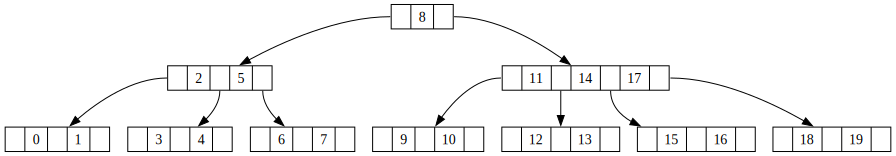

In [463]:
btree = ArbreB(2)
# btree.ajout(2)
# btree.ajout(11)
# btree.ajout(16)
# btree.ajout(21)
# # btree.ajout(9)
for i in range(20):
    # i = randint(1,200)
    # print("ajout de cle ",i)
    btree.ajout(i)

# if btree.recherche(16):
#     print("j'ai trouve !")
# else:
#     print("recherche echouee ?")

dot = visualiser_arbre(btree)
dot
# print(dot.source) 

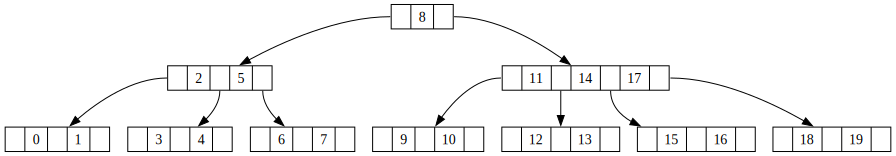

In [464]:
duplique = btree._duplique()
dot2 = visualiser_arbre(duplique)
dot2

mes cles ! [8]
indice enfant où chercher cle pred 0
cle pred à cle ! 7 8
mes cles ! [2, 5]
continuer a chercher dans la page suivante 7
mes cles ! [6, 7]
je suis une feuille ! [6, 7] suppression de 7
apres suppression feuille, je verifie les prop de l'arbre ! [6]
je suis en deficit ! [6]
je suis [6] et je cherche mon frere gauche
j'ai un parent ! [2, 5]
emprunt impossible ! [6]
fusion avec frere gauche ! [3, 4]
je suis [3, 4, 5, 6] et j'ai fini de supprimer 7 et je verifie les prop de l'arbre !
parent ! [2]
parent en deficit ! [2]
je suis [2] et je cherche mon frere gauche
j'ai un parent ! [7]
parent peut emprunter ! [2]
emprunt frere droit parent ! [11, 14, 17]


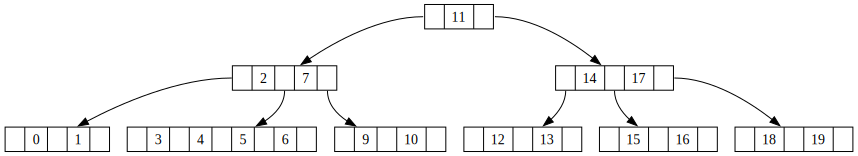

In [465]:
duplique.suppression(8)
dot0 = visualiser_arbre(duplique)
dot0

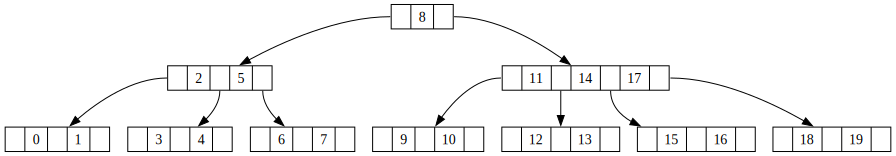

In [466]:
dot = visualiser_arbre(btree)
dot

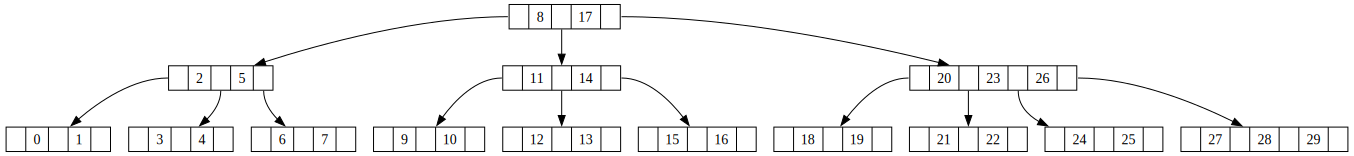

In [467]:
btree3 = ArbreB(2)
for i in range(30):
    # k = randint(1,20)
    # print("ajout de cle ",k)
    btree3.ajout(i)
dot3 = visualiser_arbre(btree3)
dot3

mes cles ! [8, 17]
indice enfant où chercher cle pred 0
cle pred à cle ! 7 8
mes cles ! [2, 5]
continuer a chercher dans la page suivante 7
mes cles ! [6, 7]
je suis une feuille ! [6, 7] suppression de 7
apres suppression feuille, je verifie les prop de l'arbre ! [6]
je suis en deficit ! [6]
je suis [6] et je cherche mon frere gauche
j'ai un parent ! [2, 5]
emprunt impossible ! [6]
fusion avec frere gauche ! [3, 4]
je suis [3, 4, 5, 6] et j'ai fini de supprimer 7 et je verifie les prop de l'arbre !
parent ! [2]
parent en deficit ! [2]
je suis [2] et je cherche mon frere gauche
j'ai un parent ! [7, 17]
parent doit fusionner ! [2]
fusion avec frere droit parent ! [11, 14]


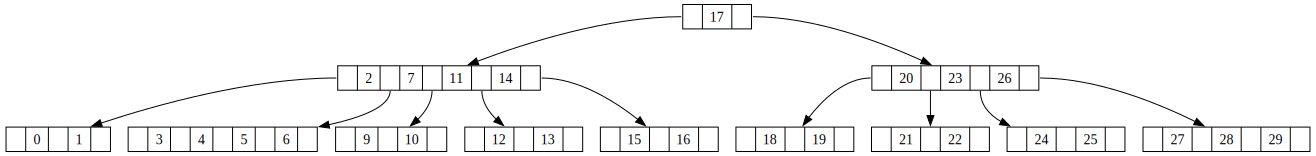

In [468]:
btree3.suppression(8)
dot4 = visualiser_arbre(btree3)
dot4

mes cles ! [17]
continuer a chercher dans la page suivante 11
mes cles ! [2, 7, 11, 14]
indice enfant où chercher cle pred 2
cle pred à cle ! 10 11
mes cles ! [9, 10]
je suis une feuille ! [9, 10] suppression de 10
apres suppression feuille, je verifie les prop de l'arbre ! [9]
je suis en deficit ! [9]
je suis [9] et je cherche mon frere gauche
j'ai un parent ! [2, 7, 10, 14]
emprunt possible ! [9]
emprunt frere gauche ! [3, 4, 5, 6]
je suis [7, 9] et j'ai fini de supprimer 10 et je verifie les prop de l'arbre !
parent ! [2, 6, 10, 14]
mes cles ! [17]
continuer a chercher dans la page suivante 14
mes cles ! [2, 6, 10, 14]
indice enfant où chercher cle pred 3
cle pred à cle ! 13 14
mes cles ! [12, 13]
je suis une feuille ! [12, 13] suppression de 13
apres suppression feuille, je verifie les prop de l'arbre ! [12]
je suis en deficit ! [12]
je suis [12] et je cherche mon frere gauche
j'ai un parent ! [2, 6, 10, 13]
emprunt impossible ! [12]
fusion avec frere gauche ! [7, 9]
je suis [7, 9,

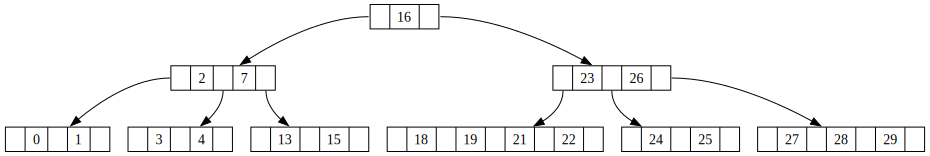

In [469]:
btree3.suppression(11)
btree3.suppression(14)
btree3.suppression(17)
btree3.suppression(20)
btree3.suppression(12)
btree3.suppression(10)
btree3.suppression(9)
btree3.suppression(5)
btree3.suppression(6)
dot5 = visualiser_arbre(btree3)
dot5

mes cles ! [16]
continuer a chercher dans la page suivante 7
mes cles ! [2, 7]
indice enfant où chercher cle pred 1
cle pred à cle ! 4 7
mes cles ! [3, 4]
je suis une feuille ! [3, 4] suppression de 4
apres suppression feuille, je verifie les prop de l'arbre ! [3]
je suis en deficit ! [3]
je suis [3] et je cherche mon frere gauche
j'ai un parent ! [2, 4]
emprunt impossible ! [3]
fusion avec frere gauche ! [0, 1]
je suis [0, 1, 2, 3] et j'ai fini de supprimer 4 et je verifie les prop de l'arbre !
parent ! [4]
parent en deficit ! [4]
je suis [4] et je cherche mon frere gauche
j'ai un parent ! [16]
parent doit fusionner ! [4]
fusion avec frere droit parent ! [23, 26]
diminution hauteur parent vide! []
je suis enfant unique ! [4, 16, 23, 26]


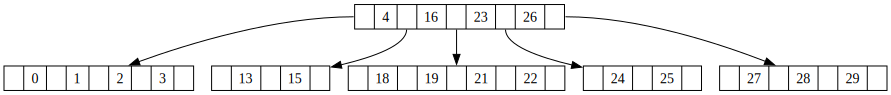

In [470]:
# btree3.ajout(17)
btree3.suppression(7)
dot6 = visualiser_arbre(btree3)
dot6